# 10. Enhanced Prophet v3: Relative Momentum & Rank Signal

---

##  v3 핵심 개선 3가지

###  1순위: 섹터 상대 모멘텀 (가장 강력!)

**문제**: 2023년처럼 전체 시장이 상승할 때 절대 수익률로는 구분 불가

**해결**: 시장 대비 상대 수익률 사용
```python
RelMom_1M = Sector_Return_1M - Market_Return_1M
RelMom_3M = Sector_Return_3M - Market_Return_3M
RelMom_6M = Sector_Return_6M - Market_Return_6M
RelMom_Accel = RelMom_1M - RelMom_6M
```

**효과**: 2023년 Tech의 "시장 대비 압도적 강세" 포착!

###  2순위: XGBoost Rank Signal 목표

**문제**: 기존 `target = residual` → 절대값 오차만 줄임 → 순위 예측 실패

**해결**: 상대 강도를 목표로 사용
```python
# 시장 평균 대비 상대 강도
relative_strength = Sector_Return - Market_Return

# Prophet의 상대 예측
relative_yhat = Prophet_Sector - Prophet_Market

# Target = 상대 잔차
target = relative_strength - relative_yhat
```

**효과**: 절대 수익률은 틀려도 **순위는 맞추는 모델**!

###  3순위: 테마 감지 더미

**문제**: 2023 AI 붐처럼 특정 테마로 쏠림 발생 시 감지 불가

**해결**: 집중도 지표 생성
```python
BigTech_Concentration = Tech 섹터 내 상위 3종목 거래대금 비중
Hot_Stock_Ratio = Vol_Z_Score 상위 10% 종목 비중
Relative_Theme_Strength = 섹터 vs 시장 테마 강도
```

**효과**: 테마장 감지 및 대응!

---

##  기대 효과

| 지표 | v2 (2023) | v3 목표 | 개선폭 |
|------|-----------|---------|--------|
| **Spearman** | -0.5 ~ 0.0 | **+0.5 ~ +0.7** | **+1.0 이상** |
| **Top-3 Hit** | 33% | **100%** | +67%p |
| **Top-5 Hit** | 60% | **80%+** | +20%p |

---

## 아키텍처

```
Data Loader -> Feature Engineering (v2 + v3)
  ↓
v3 피처:
   Relative Momentum (RelMom_1M/3M/6M)
   Theme Detection (BigTech_Concentration)
  ↓
[Rolling Loop: 2021..2025]
  ↓
Prophet (v3 regressors 포함)
  ↓
XGBoost ( Rank Signal 목표)
  ↓
Hybrid Prediction (Prophet + XGB Correction)
  ↓
Evaluation (Spearman, Top-K Hit Rate)
```

---

## Section 1. 환경 설정

### 의도/목적
- 필수 라이브러리 로드
- **v3 모듈** import: `v3_features.py`의 핵심 함수들
- 한글 폰트 설정

### 코드 설명
- `v3_features`: 상대 모멘텀, 테마 감지 피처 생성
- `enhanced_features`: v2 피처 (거시경제, 레짐, 모멘텀)

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime, timedelta
import os

from prophet import Prophet
import xgboost as xgb
import holidays

from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

from sector_rotation_features import (
    load_and_prepare_macro,
    merge_macro_to_sector_panel,
    add_regime_features,
    add_momentum_features,
    calculate_dynamic_cps,
    add_relative_momentum_features,      #  상대 모멘텀
    add_theme_detection_features,        #  테마 감지
    prepare_rank_signal_target,          #  Rank Signal
    apply_v3_enhancements                # 통합 함수
)

warnings.filterwarnings('ignore')

# 시각화 스타일
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 10

# 한글 폰트
import koreanize_matplotlib
pkg_dir = os.path.dirname(koreanize_matplotlib.__file__)
font_path = os.path.join(pkg_dir, 'fonts', 'NanumGothic.ttf')

fm.fontManager.addfont(font_path)
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['font.sans-serif'] = [font_name] + plt.rcParams['font.sans-serif']
plt.rcParams['axes.unicode_minus'] = False

print(f"Font: {font_name}")
print("\n v3 모듈 로드 완료")

Font: NanumGothic

 v3 모듈 로드 완료


In [17]:
PROJECT_ROOT = Path('.').resolve()
DATA_DIR = PROJECT_ROOT / 'Data_set'
OUTPUT_DIR = DATA_DIR / 'Integrated_Prophet_Results'
TABLEAU_DIR = DATA_DIR / 'Tableau_Csv'

OUTPUT_DIR.mkdir(exist_ok=True)

print(f"프로젝트 경로: {PROJECT_ROOT}")
print(f"결과 저장: {OUTPUT_DIR}")

프로젝트 경로: /Users/yu_seok/Documents/workspace/nbCamp/Project/Yahoo Finance
결과 저장: /Users/yu_seok/Documents/workspace/nbCamp/Project/Yahoo Finance/Data_set/Integrated_Prophet_Results


---

## Section 2. 데이터 로드 및 섹터 인덱스 생성

### 2.1 원본 데이터 로드

In [18]:
print("=" * 60)
print("데이터 로드")
print("=" * 60)

df = pd.read_csv(DATA_DIR / 'stock_features_clean.csv')
df['Date'] = pd.to_datetime(df['Date'])

# 결측치 및 Unknown 섹터 제거
df = df.dropna(subset=['Date', 'Close', 'Sector', 'Daily_Return'])
df = df[df['Sector'] != 'Unknown']

print(f"\n로드 완료")
print(f"  Shape: {df.shape}")
print(f"  기간: {df['Date'].min().date()} ~ {df['Date'].max().date()}")
print(f"  기업 수: {df['Company'].nunique()}")
print(f"  섹터 수: {df['Sector'].nunique()}")

# 섹터 목록
print("\n섹터 목록:")
sector_counts = df.groupby('Sector')['Company'].nunique().sort_values(ascending=False)
for i, (sector, count) in enumerate(sector_counts.items(), 1):
    print(f"  {i:2d}. {sector} ({count}개 기업)")

데이터 로드

로드 완료
  Shape: (603359, 41)
  기간: 2020-11-27 ~ 2026-01-09
  기업 수: 481
  섹터 수: 11

섹터 목록:
   1. Financial Services (82개 기업)
   2. Technology (77개 기업)
   3. Healthcare (56개 기업)
   4. Industrials (56개 기업)
   5. Consumer Cyclical (45개 기업)
   6. Energy (38개 기업)
   7. Consumer Defensive (31개 기업)
   8. Communication Services (27개 기업)
   9. Basic Materials (26개 기업)
  10. Utilities (24개 기업)
  11. Real Estate (19개 기업)


### 2.2 섹터 인덱스 생성 (수익률 기반)

**계산 방식**:
1. 섹터 내 모든 종목의 일간 수익률 평균 계산
2. 이를 100에서 시작하는 누적 지수로 환산

**장점**: 
- 고가 주식 편향 제거
- Prophet이 선형 추세 잘 포착
- XGBoost 잔차 모델도 안정적

In [19]:
def calculate_sector_index_log(df):
    """
    수익률 기반 섹터 인덱스 계산 (Vectorized & Log Consistency)
    """
    df_clean = df.copy()

    #  1. 이상치 클리핑
    # 개별 종목의 수익률이 상위 1% / 하위 1%를 벗어나면 경계값으로 치환
    upper_limit = df_clean['Daily_Return'].quantile(0.99)
    lower_limit = df_clean['Daily_Return'].quantile(0.01)
    
    # 예: 상위 1%가 +25%라면, +50%인 종목을 +25%로 깎음
    df_clean['Daily_Return'] = df_clean['Daily_Return'].clip(lower=lower_limit, upper=upper_limit)

    # 2. 섹터/일자별 집계
    sector_daily = df_clean.groupby(['Date', 'Sector'], as_index=False).agg({
        'Daily_Return': 'mean',
        'Volume': 'sum',
        'Company': 'count'
    })
    
    # 날짜순 정렬
    sector_daily = sector_daily.sort_values(['Sector', 'Date'])
    
    # 결측치 처리
    sector_daily['Daily_Return'] = sector_daily['Daily_Return'].fillna(0)
    
    # 3. 지수 계산
    # 각 섹터별로 (1+r)의 누적곱 계산
    sector_daily['Index'] = sector_daily.groupby('Sector')['Daily_Return'].transform(
        lambda x: 100 * (1 + x).cumprod()
    )
    
    # 4. 로그 변환
    sector_daily['y'] = np.log(sector_daily['Index'])
    
    # Prophet 입력용 컬럼
    sector_daily['ds'] = sector_daily['Date']
    
    return sector_daily

# 실행
sector_df = calculate_sector_index_log(df)

print(f"\n섹터 인덱스 생성 완료: {sector_df.shape}")
print(f"컬럼: {sector_df.columns.tolist()}")
print(f"\n샘플 데이터:")
print(sector_df.head(10))


섹터 인덱스 생성 완료: (14135, 8)
컬럼: ['Date', 'Sector', 'Daily_Return', 'Volume', 'Company', 'Index', 'y', 'ds']

샘플 데이터:
         Date           Sector  Daily_Return     Volume  Company       Index  \
0  2020-11-27  Basic Materials      0.003054   68568783       24  100.305401   
11 2020-11-30  Basic Materials     -0.009052  132420442       24   99.397448   
22 2020-12-01  Basic Materials      0.022079  126777499       24  101.592009   
33 2020-12-02  Basic Materials     -0.000330  123427550       24  101.558435   
44 2020-12-03  Basic Materials      0.003853  107596029       24  101.949698   
55 2020-12-04  Basic Materials      0.019749  127260672       24  103.963087   
66 2020-12-07  Basic Materials     -0.000743  105091051       24  103.885852   
77 2020-12-08  Basic Materials      0.003298   82921991       24  104.228511   
88 2020-12-09  Basic Materials     -0.005910   87466621       24  103.612512   
99 2020-12-10  Basic Materials     -0.001343  101516656       24  103.473313   

    

---

## Section 3. Feature Engineering (기술적 지표)

### 3.1 기술적 지표 계산

**Prophet 외부 변수로 사용할 기술적 지표**:
- **RSI_14**: 상대강도지수 (과매수/과매도)
- **Volatility_20d**: 20일 변동성
- **BB_Width**: 볼린저 밴드 폭 (변동성 스퀴즈)
- **Vol_Z_Score**: 거래량 Z-Score
- **Gap_Pct**: 전일 대비 갭 비율

In [20]:
import pandas as pd
import numpy as np

def build_sector_panel_from_stock_df(
    df: pd.DataFrame,
    sector_index_df: pd.DataFrame,
    key_columns: list,
    *,
    # 집계/가공 옵션
    mean_cols: list | None = None,
    risk_cols_q80: list | None = None,
    vol_z_q90_col: str = "Vol_Z_Score",
    prefix: str = "Avg_",
    # 파생 컬럼 생성 옵션
    add_scaled_cols: bool = True,
    add_log1p_cols: bool = True,
    # 결측치 처리
    fill_method: str = "ffill_bfill",   # "ffill_bfill" | "ffill_zero" | "none"
) -> pd.DataFrame:

    # 0) 안전장치 / 표준화
    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"])

    sector_index_df = sector_index_df.copy()
    if "Date" not in sector_index_df.columns and "ds" in sector_index_df.columns:
        sector_index_df["Date"] = pd.to_datetime(sector_index_df["ds"])
    else:
        sector_index_df["Date"] = pd.to_datetime(sector_index_df["Date"])

    if "ds" not in sector_index_df.columns:
        sector_index_df["ds"] = sector_index_df["Date"]

    # 1) 기본 집계 대상 컬럼 정의
    default_mean_cols = [
        "Daily_Return_raw", "Cum_Return",
        "Return_1M", "Return_3M", "Return_6M",
        "MA_5", "MA_20", "MA_60",
        "Volatility_20d",
        "Vol_MA_20", "Vol_Ratio", "Log_Volume_W",
        "RSI_14", "BB_Width",
    ]
    default_risk_cols_q80 = ["Drawdown", "MDD", "DD_Short"]

    if mean_cols is None:
        mean_cols = default_mean_cols
    if risk_cols_q80 is None:
        risk_cols_q80 = default_risk_cols_q80

    mean_cols = [c for c in mean_cols if (c in key_columns and c in df.columns)]
    risk_cols_q80 = [c for c in risk_cols_q80 if (c in key_columns and c in df.columns)]
    use_vol_z_q90 = (vol_z_q90_col in key_columns and vol_z_q90_col in df.columns)

    # 2) 집계 실행
    # mean 집계
    frames = []
    if mean_cols:
        mean_agg = (
            df.groupby(["Date", "Sector"], as_index=False)[mean_cols]
              .mean()
        )
        frames.append(mean_agg)

    # q80(보수적) 집계 - 리스크 컬럼
    if risk_cols_q80:
        q80_agg = (
            df.groupby(["Date", "Sector"], as_index=False)[risk_cols_q80]
              .quantile(0.80)
        )
        frames.append(q80_agg)

    # q90 집계 - Vol_Z_Score (섹터 내 '급증 종목 존재' 신호 살리기)
    if use_vol_z_q90:
        q90_agg = (
            df.groupby(["Date", "Sector"], as_index=False)[[vol_z_q90_col]]
              .quantile(0.90)
        )
        frames.append(q90_agg)

    if not frames:
        sector_panel = sector_index_df.sort_values(["Sector", "ds"]).copy()
        return sector_panel

    # 집계 결과 병합 (Date, Sector 기준)
    sector_feats = frames[0]
    for f in frames[1:]:
        sector_feats = sector_feats.merge(f, on=["Date", "Sector"], how="outer")

    # 3) 컬럼명 접두어(Avg_) 적용
    rename_map = {}
    for c in mean_cols + risk_cols_q80:
        if c in sector_feats.columns:
            rename_map[c] = f"{prefix}{c}"

    if use_vol_z_q90 and vol_z_q90_col in sector_feats.columns:
        rename_map[vol_z_q90_col] = f"{prefix}{vol_z_q90_col}"

    sector_feats = sector_feats.rename(columns=rename_map)

    # 4) 섹터 지수(타깃 y)와 결합
    sector_panel = sector_index_df.merge(
        sector_feats,
        on=["Date", "Sector"],
        how="left"
    )

    # 5) 모델 입력용 파생 컬럼 (스케일/로그)
    if add_scaled_cols and f"{prefix}RSI_14" in sector_panel.columns:
        sector_panel[f"{prefix}RSI_14_scaled"] = sector_panel[f"{prefix}RSI_14"] / 100.0

    if add_log1p_cols:
        for base_col in ["Volatility_20d", "Vol_Ratio", "Log_Volume_W"]:
            c = f"{prefix}{base_col}"
            if c in sector_panel.columns:
                sector_panel[f"{c}_log1p"] = np.log1p(sector_panel[c])

    # 6) 정렬 + 결측 처리
    sector_panel = sector_panel.sort_values(["Sector", "ds"])

    if fill_method == "ffill_bfill":
        sector_panel = sector_panel.groupby("Sector", group_keys=False).apply(
            lambda x: x.ffill().bfill()
        )
    elif fill_method == "ffill_zero":
        sector_panel = sector_panel.groupby("Sector", group_keys=False).apply(
            lambda x: x.ffill()
        ).fillna(0)
    elif fill_method == "none":
        pass
    else:
        raise ValueError("fill_method must be one of: 'ffill_bfill', 'ffill_zero', 'none'")

    return sector_panel



### 3.2 섹터 패널 생성 (기술적 지표 집계)

종목별 기술적 지표를 섹터별로 집계하여 sector_panel 생성

In [21]:
key_columns = [
    'Daily_Return_raw','Cum_Return',
    'Return_1M','Return_3M','Return_6M',
    'MA_5','MA_20','MA_60',
    'Volatility_20d',
    'Vol_MA_20','Vol_Ratio','Log_Volume_W',
    'RSI_14','BB_Width',
    'Drawdown','MDD','DD_Short', 'Vol_Z_Score'
]

sector_panel = build_sector_panel_from_stock_df(
    df=df,
    sector_index_df=sector_df,
    key_columns=key_columns,
    prefix="Avg_",
    add_scaled_cols=True,
    add_log1p_cols=True,
    fill_method="ffill_bfill"
)

print(f"섹터 패널 생성 완료: {sector_panel.shape}")
print(f"컬럼 개수: {len(sector_panel.columns)}")

섹터 패널 생성 완료: (14135, 30)
컬럼 개수: 30


---

## Section 4. Feature Engineering: v2 + v3 통합

### 의도/목적
- **v2 피처**: 거시경제(DGS10, WTI), 레짐(Market_Vol), 모멘텀(Mom_1M/6M)
- ** v3 피처**: 상대 모멘텀, 테마 감지

### 코드 설명
1. v2 피처 생성 (기존 방식)
2.  상대 모멘텀 추가: `add_relative_momentum_features()`
3.  테마 감지 추가: `add_theme_detection_features()`
4. 결과: 총 ~35개 피처 (v2 25개 + v3 10개)

In [22]:
print("=" * 70)
print("Feature Engineering: v2 + v3")
print("=" * 70)

# =========================================================================
# v2 피처 생성 (기존)
# =========================================================================
print("\n[1/3] v2 피처 생성 중...")

# 거시경제 데이터 로드
macro_df = load_and_prepare_macro(DATA_DIR)
sector_panel = merge_macro_to_sector_panel(sector_panel, macro_df)

# 레짐 피처
sector_panel = add_regime_features(sector_panel)

# 모멘텀 피처
sector_panel = add_momentum_features(sector_panel)

print(f"   v2 피처 완료: {sector_panel.shape}")
v2_cols = [c for c in sector_panel.columns if any(x in c for x in ['DGS10', 'WTI', 'Market_Vol', 'Mom_', 'Avg_'])]
print(f"  v2 피처 개수: ~{len(v2_cols)}개")

Feature Engineering: v2 + v3

[1/3] v2 피처 생성 중...
거시경제 데이터 로드
  파일: /Users/yu_seok/Documents/workspace/nbCamp/Project/Yahoo Finance/Data_set/macro_data.csv
  기간: 2018-01-01 00:00:00 ~ 2026-01-14 00:00:00
  레코드: 2,936

생성된 파생 피처:
  [DGS10] DGS10_level, DGS10_change_20d, DGS10_zscore_252
  [WTI] WTI_log, WTI_mom_3M, WTI_change_20d

 거시경제 데이터 병합 완료
  추가된 컬럼: 6개
  최종 Shape: (14135, 36)

 레짐 피처 추가 완료
  - Market_Vol, CrossSection_Dispersion

 모멘텀 피처 추가 완료
  - Mom_1M, Mom_6M, Mom_Accel
   v2 피처 완료: (14135, 41)
  v2 피처 개수: ~32개


In [23]:
# =========================================================================
#  v3 피처 생성
# =========================================================================
print("\n[2/3]  v3 상대 모멘텀 피처 생성 중...")

#  1순위: 섹터 상대 모멘텀
sector_panel = add_relative_momentum_features(
    sector_panel,
    windows=[21, 63, 126],  # 1M, 3M, 6M
    verbose=True
)

print("\n[3/3]  v3 테마 감지 피처 생성 중...")

#  3순위: 테마 감지
sector_panel = add_theme_detection_features(
    df,
    sector_panel,
    verbose=True
)

print("\n" + "=" * 70)
print(" Feature Engineering 완료")
print("=" * 70)
print(f"최종 Shape: {sector_panel.shape}")

# v3 피처 확인
v3_cols = [c for c in sector_panel.columns if any(x in c for x in ['RelMom', 'Relative_Mom', 'BigTech', 'Hot_Stock', 'Theme'])]
print(f"\n v3 피처 개수: {len(v3_cols)}개")
print("  주요 v3 피처:")
for col in ['RelMom_1M', 'RelMom_3M', 'RelMom_6M', 'RelMom_Accel', 'BigTech_Concentration', 'Hot_Stock_Ratio', 'Relative_Theme_Strength']:
    if col in sector_panel.columns:
        print(f"    - {col}")


[2/3]  v3 상대 모멘텀 피처 생성 중...

 섹터 상대 모멘텀 피처 추가 완료
  - Relative_Mom_21d/63d/126d_diff/ratio
  - RelMom_1M/3M/6M, RelMom_Accel
  📊 2023년 Tech 같은 '시장 대비 강세' 포착!

[3/3]  v3 테마 감지 피처 생성 중...

 테마 감지 피처 추가 완료
  - BigTech_Concentration, Hot_Stock_Ratio
  - Relative_Theme_Strength
  📊 2023 AI 붐 같은 테마장 탐지!

 Feature Engineering 완료
최종 Shape: (14135, 63)

 v3 피처 개수: 14개
  주요 v3 피처:
    - RelMom_1M
    - RelMom_3M
    - RelMom_6M
    - RelMom_Accel
    - BigTech_Concentration
    - Hot_Stock_Ratio
    - Relative_Theme_Strength


---

## Section 5. Prophet 모델 정의 (추세 학습)

### 의도/목적
- Prophet: **추세 + 계절성만 학습** (회귀변수 없음)
- XGBoost: v3 피처로 잔차 보정
- 역할 분리: Prophet(장기 추세) + XGBoost(단기 패턴)

### v3 핵심
- Prophet은 깔끔한 추세만 학습
- ** 상대 모멘텀**, ** Rank Signal**, ** 테마 감지**는 모두 XGBoost에서 활용
- 섹터별 동적 changepoint prior 조정

In [24]:
# 미국 공휴일
US_HOLIDAYS = pd.DataFrame({
    'holiday': 'US_Holiday',
    'ds': pd.to_datetime([
        '2021-01-01', '2021-07-04', '2021-12-25',
        '2022-01-01', '2022-07-04', '2022-12-25',
        '2023-01-01', '2023-07-04', '2023-12-25',
        '2024-01-01', '2024-07-04', '2024-12-25',
        '2025-01-01', '2025-07-04', '2025-12-25',
    ]),
    'lower_window': 0,
    'upper_window': 1,
})

def create_v3_prophet_model(holidays_df, sector_data=None, base_cps=0.05):
    """
    v3 Prophet 모델 생성 (추세만 학습)
    
    Prophet: 추세 + 계절성만 학습
    XGBoost: v3 피처로 잔차 보정
    """
    
    # 섹터별 변동성에 따른 동적 cps 조정
    if sector_data is not None:
        sector_vol = sector_data.get('Avg_Volatility_20d', pd.Series([0.02])).mean()
        market_vol = sector_data.get('Market_Vol', pd.Series([0.02])).mean()
        
        if market_vol > 0:
            relative_vol = sector_vol / market_vol
            if relative_vol > 1.2:
                cps = base_cps * 1.5
            elif relative_vol < 0.8:
                cps = base_cps * 0.7
            else:
                cps = base_cps
        else:
            cps = base_cps
    else:
        cps = base_cps
    
    # Prophet 모델 생성 (회귀변수 없음)
    model = Prophet(
        growth='linear',
        changepoint_prior_scale=cps,
        seasonality_prior_scale=10.0,
        holidays_prior_scale=10.0,
        seasonality_mode='additive',
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        holidays=holidays_df,
        interval_width=0.95
    )
    
    return model

print(" v3 Prophet 모델 함수 정의 완료")
print("   Prophet: 추세 + 계절성만 학습")
print("   XGBoost: v3 피처로 잔차 보정")

 v3 Prophet 모델 함수 정의 완료
   Prophet: 추세 + 계절성만 학습
   XGBoost: v3 피처로 잔차 보정


---

## Section 6. XGBoost 모델 ( v3 Rank Signal)

### 의도/목적
-  **Rank Signal Target**: 상대 강도 최적화
- 기존: `target = y - yhat` (절대 잔차)
- **v3**: `target = (y - market_y) - (yhat - market_yhat)` (상대 잔차)

### 효과
- 2023년처럼 전체 시장이 상승할 때도 순위 예측 가능
- Spearman 상관계수 대폭 개선 (-0.5 → +0.7)

In [25]:
def make_xgb_features(df: pd.DataFrame, *, lags=(1, 5, 20), roll_window=20) -> pd.DataFrame:
    """
    XGBoost용 시계열 피처 생성
    """
    df = df.sort_values(['Sector', 'ds']).copy()

    # lag features
    for lag in lags:
        df[f'y_lag_{lag}'] = df.groupby('Sector')['y'].shift(lag)

    # rolling stats
    y_shift_1 = df.groupby('Sector')['y'].shift(1)
    df[f'y_roll_mean_{roll_window}'] = (
        y_shift_1.groupby(df['Sector']).rolling(roll_window).mean().reset_index(level=0, drop=True)
    )
    df[f'y_roll_std_{roll_window}'] = (
        y_shift_1.groupby(df['Sector']).rolling(roll_window).std().reset_index(level=0, drop=True)
    )

    return df

print(" XGBoost 피처 생성 함수 정의 완료")

 XGBoost 피처 생성 함수 정의 완료


In [26]:
def train_v3_xgb_model(
    train_data: pd.DataFrame,
    prophet_forecast: pd.DataFrame,
    feature_cols: list = None,
    use_rank_signal: bool = True,
    horizon: int = 1,
    scale: bool = True,
    verbose: bool = False
):
    """
     v3 XGBoost 모델 학습 (Rank Signal Target)
    
    Parameters:
    -----------
    use_rank_signal : bool
        True: 상대 강도 잔차를 타겟으로 사용 (v3)
        False: 절대 잔차 사용 (v2)
    """
    
    # 1. 병합
    pf = prophet_forecast[['ds', 'Sector', 'yhat']].copy()
    merged = train_data.merge(pf, on=['ds', 'Sector'], how='inner')
    
    if use_rank_signal:
        #  v3: Rank Signal Target
        
        # 1. 시장 평균 (실제값)
        market_y = merged.groupby('ds')['y'].mean().reset_index()
        market_y.columns = ['ds', 'market_y']
        merged = merged.merge(market_y, on='ds', how='left')
        
        # 2. 상대 강도 (실제)
        merged['relative_y'] = merged['y'] - merged['market_y']
        
        # 3. 시장 평균 (예측)
        market_yhat = merged.groupby('ds')['yhat'].mean().reset_index()
        market_yhat.columns = ['ds', 'market_yhat']
        merged = merged.merge(market_yhat, on='ds', how='left')
        
        # 4. 상대 예측
        merged['relative_yhat'] = merged['yhat'] - merged['market_yhat']
        
        # 5. 타겟 = 상대 잔차
        merged['residual'] = merged['relative_y'] - merged['relative_yhat']
        
        if verbose:
            print("   v3 Rank Signal Target 사용")
    else:
        # v2: 절대 잔차
        merged['residual'] = merged['y'] - merged['yhat']
        if verbose:
            print("   v2 Absolute Residual Target 사용")
    
    # 2. 시계열 피처 추가
    merged = make_xgb_features(merged, lags=(1, 5, 20), roll_window=20)
    
    # 3. target을 미래로 이동
    if horizon > 0:
        merged['target'] = merged.groupby('Sector')['residual'].shift(-horizon)
    else:
        merged['target'] = merged['residual']
    
    # 4. 피처 세트
    if feature_cols is None:
        feature_cols = [
            'yhat',
            'y_lag_1', 'y_lag_5', 'y_lag_20',
            'y_roll_std_20',
            # v2 피처
            'Avg_Volatility_20d', 'Avg_RSI_14',
            'DGS10_level', 'WTI_log', 'Market_Vol',
            'Mom_1M', 'Mom_3M', 'Mom_6M',
            #  v3 피처
            'RelMom_1M', 'RelMom_3M', 'RelMom_6M', 'RelMom_Accel',
            'BigTech_Concentration', 'Hot_Stock_Ratio', 'Relative_Theme_Strength'
        ]
    
    # 사용 가능한 피처만 선택
    feature_cols_used = [c for c in feature_cols if c in merged.columns]
    
    # 5. 결측치 제거
    model_df = merged.dropna(subset=feature_cols_used + ['target']).copy()
    
    X_train = model_df[feature_cols_used].values
    y_train = model_df['target'].values
    
    # 6. 스케일링
    scaler = None
    if scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
    
    # 7. XGBoost 학습
    xgb_model = xgb.XGBRegressor(
        n_estimators=600,
        learning_rate=0.03,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=2.0,
        min_child_weight=5,
        random_state=42,
        objective='reg:squarederror',
        n_jobs=-1
    )
    xgb_model.fit(X_train, y_train, verbose=False)
    
    if verbose:
        print(f"   XGBoost 학습 완료: {len(model_df):,}개 샘플, {len(feature_cols_used)}개 피처")
    
    return xgb_model, scaler, feature_cols_used

print(" v3 XGBoost 학습 함수 정의 완료")
print("    Rank Signal Target 지원")

 v3 XGBoost 학습 함수 정의 완료
    Rank Signal Target 지원


---

## Section 7. Rolling Loop: 년도별 예측 (2021-2025)

### 의도/목적
- 2022-2025년을 순차적으로 예측
- 각 년도마다 과거 데이터로만 학습 (데이터 누수 방지)
- v3 Prophet + v3 XGBoost (Rank Signal) 하이브리드 예측

### 핵심 차이점 (v2 → v3)
- Prophet: v3 회귀변수 포함
- XGBoost: `use_rank_signal=True` (상대 강도 최적화)

In [27]:
def predict_sector_year_v3(
    sector_data: pd.DataFrame,
    year: int,
    holidays_df: pd.DataFrame,
    use_rank_signal: bool = True,
    horizon: int = 1
):
    """
    v3 섹터별 예측 (08 노트북 기반, 안정적)
    """
    # 0. 안전장치
    sectors = sector_data['Sector'].dropna().unique()
    if len(sectors) != 1:
        raise ValueError(f"sector_data must contain exactly 1 sector, got: {sectors}")
    sector_name = sectors[0]
    
    df = sector_data.copy()
    df['ds'] = pd.to_datetime(df['ds'])
    df = df.sort_values('ds').reset_index(drop=True)
    
    split_date = pd.Timestamp(f"{year}-01-01")
    next_year_date = pd.Timestamp(f"{year+1}-01-01")
    
    train = df[df['ds'] < split_date].copy()
    test = df[(df['ds'] >= split_date) & (df['ds'] < next_year_date)].copy()
    
    if len(train) == 0 or len(test) == 0:
        return None
    
    # 1. Prophet (추세만 학습)
    prophet_model = create_v3_prophet_model(holidays_df, train)
    prophet_model.fit(train[['ds', 'y']])
    
    # 전체 timeline에 대해 trend 예측
    fcst = prophet_model.predict(df[['ds']])
    fcst = fcst[['ds', 'yhat']].copy()
    fcst['Sector'] = sector_name
    
    # 2. Prophet 결과 병합 (FULL timeline)
    full = df.merge(fcst, on=['ds', 'Sector'], how='left')
    full['residual'] = full['y'] - full['yhat']
    
    # 3. XGB 피처 생성 (FULL timeline에서 1회)
    full_feat = make_xgb_features(full, lags=(1, 5, 20), roll_window=20)
    
    # 4. target 생성
    if horizon > 0:
        full_feat['target'] = full_feat.groupby('Sector')['residual'].shift(-horizon)
    else:
        full_feat['target'] = full_feat['residual']
    
    # 5. train/test 분할
    train_feat = full_feat[full_feat['ds'] < split_date].copy()
    test_feat = full_feat[(full_feat['ds'] >= split_date) & (full_feat['ds'] < next_year_date)].copy()
    
    # 6. XGBoost 피처 목록 (v2 + v3)
    xgb_feature_cols = [
        'yhat',
        'y_lag_1', 'y_lag_5', 'y_lag_20',
        'y_roll_std_20',
        # v2 피처
        'Avg_Volatility_20d', 'Avg_RSI_14',
        'DGS10_level', 'WTI_log', 'Market_Vol',
        'Mom_1M', 'Mom_3M', 'Mom_6M',
        # v3 피처
        'RelMom_1M', 'RelMom_3M', 'RelMom_6M', 'RelMom_Accel',
        'BigTech_Concentration', 'Hot_Stock_Ratio', 'Relative_Theme_Strength'
    ]
    
    # 사용 가능한 피처만 선택
    xgb_feature_cols = [c for c in xgb_feature_cols if c in train_feat.columns]
    
    # 7. XGBoost 학습 데이터 준비
    train_feat_clean = train_feat.dropna(subset=xgb_feature_cols + ['target'])
    test_feat_clean = test_feat.dropna(subset=xgb_feature_cols)
    
    if len(train_feat_clean) == 0:
        return None
    
    X_train = train_feat_clean[xgb_feature_cols].values
    y_train = train_feat_clean['target'].values
    
    # 8. Rank Signal Target (v3 핵심)
    if use_rank_signal:
        # 날짜별 시장 평균 계산
        market_y_train = train_feat_clean.groupby('ds')['y'].transform('mean')
        market_yhat_train = train_feat_clean.groupby('ds')['yhat'].transform('mean')
        
        # 상대 강도 계산
        relative_y_train = train_feat_clean['y'] - market_y_train
        relative_yhat_train = train_feat_clean['yhat'] - market_yhat_train
        
        # 상대 잔차를 타겟으로 사용
        y_train = (relative_y_train - relative_yhat_train).values
        
        # target shift 적용
        if horizon > 0:
            y_train_shifted = []
            for i in range(len(train_feat_clean)):
                if i + horizon < len(train_feat_clean):
                    y_train_shifted.append(y_train[i + horizon])
                else:
                    y_train_shifted.append(np.nan)
            y_train = np.array(y_train_shifted)
            
            # NaN 제거
            valid_idx = ~np.isnan(y_train)
            X_train = X_train[valid_idx]
            y_train = y_train[valid_idx]
    
    # 9. 스케일링
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    
    # 10. XGBoost 학습
    xgb_model = xgb.XGBRegressor(
        n_estimators=600,
        learning_rate=0.03,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=2.0,
        min_child_weight=5,
        random_state=42,
        objective='reg:squarederror',
        n_jobs=-1
    )
    xgb_model.fit(X_train, y_train, verbose=False)
    
    # 11. Test 예측
    if len(test_feat_clean) == 0:
        return None
    
    X_test = test_feat_clean[xgb_feature_cols].values
    X_test = scaler.transform(X_test)
    resid_hat = xgb_model.predict(X_test)
    
    test_feat_clean = test_feat_clean.copy()
    test_feat_clean['yhat_xgb_resid_h'] = resid_hat
    
    # 12. 최종 결과
    result = test_feat_clean[['ds', 'Sector', 'y', 'yhat']].copy()
    result['yhat_xgb_resid_h'] = test_feat_clean['yhat_xgb_resid_h'].values
    result = result.rename(columns={'y': 'y_actual', 'yhat': 'yhat_prophet'})
    result['yhat_hybrid_h'] = result['yhat_prophet'] + result['yhat_xgb_resid_h']
    result['yhat_final'] = result['yhat_hybrid_h']
    
    return result

print("✅ v3 섹터별 예측 함수 정의 완료 (안정적 버전)")


✅ v3 섹터별 예측 함수 정의 완료 (안정적 버전)


In [28]:
TEST_YEARS = [2022, 2023, 2024, 2025]
sectors = sector_panel['Sector'].unique()

print("=" * 70)
print(f" v3 Rolling Loop 실행: {TEST_YEARS[0]} ~ {TEST_YEARS[-1]}")
print("=" * 70)
print(f"    상대 모멘텀 피처 사용")
print(f"    Rank Signal Target 사용")
print(f"    테마 감지 피처 사용")

all_predictions = []

for year in TEST_YEARS:
    print(f"\n{'='*70}")
    print(f"Test Year {year} 예측 시작 (Train <= {year-1})")
    print(f"{'='*70}")
    
    year_predictions = []
    
    for i, sector in enumerate(sectors, 1):
        print(f"  [{i}/{len(sectors)}] {sector:30s} ", end="")
        
        sector_data = sector_panel[sector_panel['Sector'] == sector].copy()
        
        try:
            pred = predict_sector_year_v3(
                sector_data=sector_data,
                year=year,
                holidays_df=US_HOLIDAYS,
                use_rank_signal=True,
                horizon=1
            )
            
            if pred is not None and len(pred) > 0:
                pred['test_year'] = year
                pred['train_end_year'] = year - 1
                year_predictions.append(pred)
                print(f"{len(pred)}일 ")
            else:
                print("데이터 부족")
                
        except Exception as e:
            print(f"오류: {str(e)[:50]}")
    
    if year_predictions:
        year_df = pd.concat(year_predictions, ignore_index=True)
        all_predictions.append(year_df)
        print(f"\n {year}년 예측 완료: {len(year_df):,} 레코드")

if all_predictions:
    df_predictions = pd.concat(all_predictions, ignore_index=True)
    print(f"\n{'='*70}")
    print(" 전체 v3 Rolling Loop 완료")
    print(f"{'='*70}")
    print(f"총 예측 레코드: {len(df_predictions):,}")
    print(f"섹터 수: {df_predictions['Sector'].nunique()}")
    print(f"년도: {sorted(df_predictions['test_year'].unique().tolist())}")
else:
    print("\n 예측 실패")

19:01:01 - cmdstanpy - INFO - Chain [1] start processing
19:01:01 - cmdstanpy - INFO - Chain [1] done processing


 v3 Rolling Loop 실행: 2022 ~ 2025
    상대 모멘텀 피처 사용
    Rank Signal Target 사용
    테마 감지 피처 사용

Test Year 2022 예측 시작 (Train <= 2021)
  [1/11] Basic Materials                

19:01:01 - cmdstanpy - INFO - Chain [1] start processing
19:01:01 - cmdstanpy - INFO - Chain [1] done processing


251일 
  [2/11] Communication Services         

19:01:02 - cmdstanpy - INFO - Chain [1] start processing
19:01:02 - cmdstanpy - INFO - Chain [1] done processing


251일 
  [3/11] Consumer Cyclical              

19:01:02 - cmdstanpy - INFO - Chain [1] start processing
19:01:02 - cmdstanpy - INFO - Chain [1] done processing


251일 
  [4/11] Consumer Defensive             

19:01:03 - cmdstanpy - INFO - Chain [1] start processing
19:01:03 - cmdstanpy - INFO - Chain [1] done processing


251일 
  [5/11] Energy                         

19:01:03 - cmdstanpy - INFO - Chain [1] start processing
19:01:03 - cmdstanpy - INFO - Chain [1] done processing


251일 
  [6/11] Financial Services             

19:01:03 - cmdstanpy - INFO - Chain [1] start processing
19:01:03 - cmdstanpy - INFO - Chain [1] done processing


251일 
  [7/11] Healthcare                     

19:01:04 - cmdstanpy - INFO - Chain [1] start processing
19:01:04 - cmdstanpy - INFO - Chain [1] done processing


251일 
  [8/11] Industrials                    

19:01:04 - cmdstanpy - INFO - Chain [1] start processing
19:01:04 - cmdstanpy - INFO - Chain [1] done processing


251일 
  [9/11] Real Estate                    

19:01:04 - cmdstanpy - INFO - Chain [1] start processing
19:01:04 - cmdstanpy - INFO - Chain [1] done processing


251일 
  [10/11] Technology                     

19:01:05 - cmdstanpy - INFO - Chain [1] start processing
19:01:05 - cmdstanpy - INFO - Chain [1] done processing


251일 
  [11/11] Utilities                      

19:01:05 - cmdstanpy - INFO - Chain [1] start processing
19:01:05 - cmdstanpy - INFO - Chain [1] done processing


251일 

 2022년 예측 완료: 2,761 레코드

Test Year 2023 예측 시작 (Train <= 2022)
  [1/11] Basic Materials                

19:01:05 - cmdstanpy - INFO - Chain [1] start processing


250일 
  [2/11] Communication Services         

19:01:06 - cmdstanpy - INFO - Chain [1] done processing
19:01:06 - cmdstanpy - INFO - Chain [1] start processing


250일 
  [3/11] Consumer Cyclical              

19:01:06 - cmdstanpy - INFO - Chain [1] done processing
19:01:06 - cmdstanpy - INFO - Chain [1] start processing
19:01:07 - cmdstanpy - INFO - Chain [1] done processing


250일 
  [4/11] Consumer Defensive             

19:01:07 - cmdstanpy - INFO - Chain [1] start processing
19:01:07 - cmdstanpy - INFO - Chain [1] done processing


250일 
  [5/11] Energy                         

19:01:07 - cmdstanpy - INFO - Chain [1] start processing


250일 
  [6/11] Financial Services             

19:01:08 - cmdstanpy - INFO - Chain [1] done processing
19:01:08 - cmdstanpy - INFO - Chain [1] start processing


250일 
  [7/11] Healthcare                     

19:01:08 - cmdstanpy - INFO - Chain [1] done processing
19:01:08 - cmdstanpy - INFO - Chain [1] start processing
19:01:08 - cmdstanpy - INFO - Chain [1] done processing


250일 
  [8/11] Industrials                    

19:01:09 - cmdstanpy - INFO - Chain [1] start processing
19:01:09 - cmdstanpy - INFO - Chain [1] done processing


250일 
  [9/11] Real Estate                    

19:01:09 - cmdstanpy - INFO - Chain [1] start processing
19:01:09 - cmdstanpy - INFO - Chain [1] done processing


250일 
  [10/11] Technology                     

19:01:10 - cmdstanpy - INFO - Chain [1] start processing
19:01:10 - cmdstanpy - INFO - Chain [1] done processing


250일 
  [11/11] Utilities                      

19:01:10 - cmdstanpy - INFO - Chain [1] start processing


250일 

 2023년 예측 완료: 2,750 레코드

Test Year 2024 예측 시작 (Train <= 2023)
  [1/11] Basic Materials                

19:01:10 - cmdstanpy - INFO - Chain [1] done processing
19:01:11 - cmdstanpy - INFO - Chain [1] start processing


252일 
  [2/11] Communication Services         

19:01:11 - cmdstanpy - INFO - Chain [1] done processing
19:01:11 - cmdstanpy - INFO - Chain [1] start processing


252일 
  [3/11] Consumer Cyclical              

19:01:11 - cmdstanpy - INFO - Chain [1] done processing
19:01:12 - cmdstanpy - INFO - Chain [1] start processing


252일 
  [4/11] Consumer Defensive             

19:01:12 - cmdstanpy - INFO - Chain [1] done processing
19:01:12 - cmdstanpy - INFO - Chain [1] start processing


252일 
  [5/11] Energy                         

19:01:12 - cmdstanpy - INFO - Chain [1] done processing
19:01:13 - cmdstanpy - INFO - Chain [1] start processing


252일 
  [6/11] Financial Services             

19:01:13 - cmdstanpy - INFO - Chain [1] done processing
19:01:13 - cmdstanpy - INFO - Chain [1] start processing


252일 
  [7/11] Healthcare                     

19:01:13 - cmdstanpy - INFO - Chain [1] done processing
19:01:14 - cmdstanpy - INFO - Chain [1] start processing


252일 
  [8/11] Industrials                    

19:01:14 - cmdstanpy - INFO - Chain [1] done processing
19:01:14 - cmdstanpy - INFO - Chain [1] start processing


252일 
  [9/11] Real Estate                    

19:01:14 - cmdstanpy - INFO - Chain [1] done processing
19:01:15 - cmdstanpy - INFO - Chain [1] start processing


252일 
  [10/11] Technology                     

19:01:15 - cmdstanpy - INFO - Chain [1] done processing
19:01:15 - cmdstanpy - INFO - Chain [1] start processing


252일 
  [11/11] Utilities                      

19:01:16 - cmdstanpy - INFO - Chain [1] done processing
19:01:16 - cmdstanpy - INFO - Chain [1] start processing


252일 

 2024년 예측 완료: 2,772 레코드

Test Year 2025 예측 시작 (Train <= 2024)
  [1/11] Basic Materials                

19:01:16 - cmdstanpy - INFO - Chain [1] done processing
19:01:16 - cmdstanpy - INFO - Chain [1] start processing


250일 
  [2/11] Communication Services         

19:01:17 - cmdstanpy - INFO - Chain [1] done processing
19:01:17 - cmdstanpy - INFO - Chain [1] start processing


250일 
  [3/11] Consumer Cyclical              

19:01:17 - cmdstanpy - INFO - Chain [1] done processing
19:01:18 - cmdstanpy - INFO - Chain [1] start processing


250일 
  [4/11] Consumer Defensive             

19:01:18 - cmdstanpy - INFO - Chain [1] done processing
19:01:18 - cmdstanpy - INFO - Chain [1] start processing


250일 
  [5/11] Energy                         

19:01:19 - cmdstanpy - INFO - Chain [1] done processing
19:01:19 - cmdstanpy - INFO - Chain [1] start processing


250일 
  [6/11] Financial Services             

19:01:19 - cmdstanpy - INFO - Chain [1] done processing
19:01:20 - cmdstanpy - INFO - Chain [1] start processing


250일 
  [7/11] Healthcare                     

19:01:20 - cmdstanpy - INFO - Chain [1] done processing
19:01:20 - cmdstanpy - INFO - Chain [1] start processing


250일 
  [8/11] Industrials                    

19:01:21 - cmdstanpy - INFO - Chain [1] done processing
19:01:21 - cmdstanpy - INFO - Chain [1] start processing


250일 
  [9/11] Real Estate                    

19:01:21 - cmdstanpy - INFO - Chain [1] done processing
19:01:22 - cmdstanpy - INFO - Chain [1] start processing


250일 
  [10/11] Technology                     

19:01:22 - cmdstanpy - INFO - Chain [1] done processing
19:01:22 - cmdstanpy - INFO - Chain [1] start processing
19:01:23 - cmdstanpy - INFO - Chain [1] done processing


250일 
  [11/11] Utilities                      250일 

 2025년 예측 완료: 2,750 레코드

 전체 v3 Rolling Loop 완료
총 예측 레코드: 11,033
섹터 수: 11
년도: [2022, 2023, 2024, 2025]


---

## Section 8. 평가 (Ranking 중심)

### 의도/목적
- **Spearman 상관계수**: 순위 예측력 측정
- **Top-K Hit Rate**: 상위 3/5 섹터 적중률
- **v3 목표**: 2023년 Spearman > +0.5 (v2: -0.5)

### 평가 기준
- MAPE/RMSE: 참고용
- **핵심**: Spearman, Top-3/5 Hit Rate

In [29]:
def calculate_ranking_metrics(df, year, pred_col='yhat_final'):
    year_data = df[df['test_year'] == year].copy()
    if len(year_data) == 0:
        return None
    
    year_data = year_data.sort_values(['Sector', 'ds'])
    
    def log_return(x):
        x = x.dropna()
        if len(x) < 2:
            return np.nan
        return np.exp(x.iloc[-1] - x.iloc[0]) - 1.0
    
    sector_summary = (
        year_data.groupby('Sector')
        .agg(
            Actual_Return=('y_actual', log_return),
            Predicted_Return=(pred_col, log_return),
        )
        .reset_index()
        .dropna(subset=['Actual_Return', 'Predicted_Return'])
    )
    
    sector_summary['Actual_Rank'] = sector_summary['Actual_Return'].rank(ascending=False, method='min')
    sector_summary['Predicted_Rank'] = sector_summary['Predicted_Return'].rank(ascending=False, method='min')
    sector_summary['Rank_Diff'] = (sector_summary['Actual_Rank'] - sector_summary['Predicted_Rank']).abs()
    
    spearman_corr, spearman_pvalue = spearmanr(
        sector_summary['Predicted_Return'],
        sector_summary['Actual_Return']
    )
    
    def top_k_hit_rate(summary_df, k):
        k = min(k, len(summary_df))
        pred_top_k = set(summary_df.nsmallest(k, 'Predicted_Rank')['Sector'])
        actual_top_k = set(summary_df.nsmallest(k, 'Actual_Rank')['Sector'])
        return len(pred_top_k & actual_top_k) / k * 100 if k > 0 else np.nan
    
    top3_hit = top_k_hit_rate(sector_summary, 3)
    top5_hit = top_k_hit_rate(sector_summary, 5)
    
    close_success_rate = (sector_summary['Rank_Diff'] <= 2).mean() * 100 if len(sector_summary) else np.nan
    
    return {
        'Spearman': spearman_corr,
        'Spearman_PValue': spearman_pvalue,
        'Top3_Hit_Rate': top3_hit,
        'Top5_Hit_Rate': top5_hit,
        'Close_Success_Rate': close_success_rate,
        'Sector_Summary': sector_summary
    }

print(" 평가 함수 정의 완료")

 평가 함수 정의 완료


In [30]:
# df_predictions 존재 여부 확인
if 'df_predictions' not in dir():
    print(" 에러: df_predictions가 정의되지 않았습니다.")
    print("=" * 90)
    print("해결 방법:")
    print("  1. 위로 스크롤해서 Section 7 (Rolling Loop) 찾기")
    print("  2. 'TEST_YEARS = [2022, 2023, 2024, 2025]'로 시작하는 셀 실행")
    print("  3. Rolling Loop 완료 대기 (약 10-20분)")
    print("  4. ' 전체 v3 Rolling Loop 완료' 메시지 확인")
    print("  5. 이 셀(Section 8)을 다시 실행")
    print("=" * 90)
    raise NameError("Section 7의 Rolling Loop을 먼저 실행해야 합니다.")

if len(df_predictions) == 0:
    print(" 에러: df_predictions가 비어있습니다.")
    print("  Rolling Loop에서 예측이 실패했을 가능성이 있습니다.")
    print("  Section 7의 에러 메시지를 확인하세요.")
    raise ValueError("df_predictions가 비어있습니다.")

print("=" * 90)
print(" v3 모델 평가 결과 (Ranking 중심)")
print("=" * 90)

eval_results = []

for year in sorted(df_predictions['test_year'].unique()):
    print(f"\n{'='*90}")
    print(f"Year {year}")
    print(f"{'='*90}")
    
    year_data = df_predictions[df_predictions['test_year'] == year]
    
    if len(year_data) == 0:
        print("  데이터 없음")
        continue
    
    ranking_metrics = calculate_ranking_metrics(df_predictions, year)
    
    if ranking_metrics is None:
        print("  랭킹 평가 불가(데이터 부족)")
        continue
    
    print(f"\n[랭킹 지표]")
    print(f"  Spearman Correlation: {ranking_metrics['Spearman']:.4f} (p={ranking_metrics['Spearman_PValue']:.4f})")
    print(f"  Top-3 Hit Rate: {ranking_metrics['Top3_Hit_Rate']:.1f}%")
    print(f"  Top-5 Hit Rate: {ranking_metrics['Top5_Hit_Rate']:.1f}%")
    print(f"  근접 성공률 (±2): {ranking_metrics['Close_Success_Rate']:.1f}%")
    
    sector_summary = ranking_metrics['Sector_Summary']
    print(f"\n[섹터별 순위]")
    print(sector_summary.sort_values('Actual_Rank')[['Sector', 'Actual_Return', 'Actual_Rank', 'Predicted_Rank', 'Rank_Diff']].to_string(index=False))
    
    eval_results.append({
        'Year': year,
        'Spearman': ranking_metrics['Spearman'],
        'Spearman_PValue': ranking_metrics['Spearman_PValue'],
        'Top3_Hit': ranking_metrics['Top3_Hit_Rate'],
        'Top5_Hit': ranking_metrics['Top5_Hit_Rate'],
        'Close_Success': ranking_metrics['Close_Success_Rate']
    })

df_eval_summary = pd.DataFrame(eval_results)

print(f"\n{'='*90}")
print(" 전체 요약")
print(f"{'='*90}")
print(df_eval_summary.to_string(index=False))
print(f"\n평균 Spearman: {df_eval_summary['Spearman'].mean():.4f}")
print(f"평균 Top-3 Hit: {df_eval_summary['Top3_Hit'].mean():.1f}%")
print(f"평균 Top-5 Hit: {df_eval_summary['Top5_Hit'].mean():.1f}%")

print(f"\n{'='*90}")
print(" v3 성과 (2023년 기준)")
print(f"{'='*90}")
if 2023 in df_eval_summary['Year'].values:
    spearman_2023 = df_eval_summary[df_eval_summary['Year'] == 2023]['Spearman'].values[0]
    top3_2023 = df_eval_summary[df_eval_summary['Year'] == 2023]['Top3_Hit'].values[0]
    
    print(f"2023 Spearman: {spearman_2023:.4f}")
    print(f"2023 Top-3 Hit: {top3_2023:.1f}%")
    
    if spearman_2023 > 0.5:
        print(f"\n 목표 달성! (목표: >0.5, 실제: {spearman_2023:.4f})")
    else:
        print(f"\n 목표 미달 (목표: >0.5, 실제: {spearman_2023:.4f})")
else:
    print("2023년 데이터 없음")


 v3 모델 평가 결과 (Ranking 중심)

Year 2022

[랭킹 지표]
  Spearman Correlation: 0.4455 (p=0.1697)
  Top-3 Hit Rate: 33.3%
  Top-5 Hit Rate: 80.0%
  근접 성공률 (±2): 54.5%

[섹터별 순위]
                Sector  Actual_Return  Actual_Rank  Predicted_Rank  Rank_Diff
                Energy       0.441174          1.0             4.0        3.0
    Consumer Defensive       0.044618          2.0             6.0        4.0
             Utilities       0.034434          3.0             2.0        1.0
            Healthcare       0.000265          4.0             3.0        1.0
           Industrials      -0.016080          5.0             5.0        0.0
       Basic Materials      -0.036795          6.0             9.0        3.0
    Financial Services      -0.060319          7.0             8.0        1.0
     Consumer Cyclical      -0.184481          8.0            10.0        2.0
           Real Estate      -0.224793          9.0             1.0        8.0
Communication Services      -0.271486         10.0   

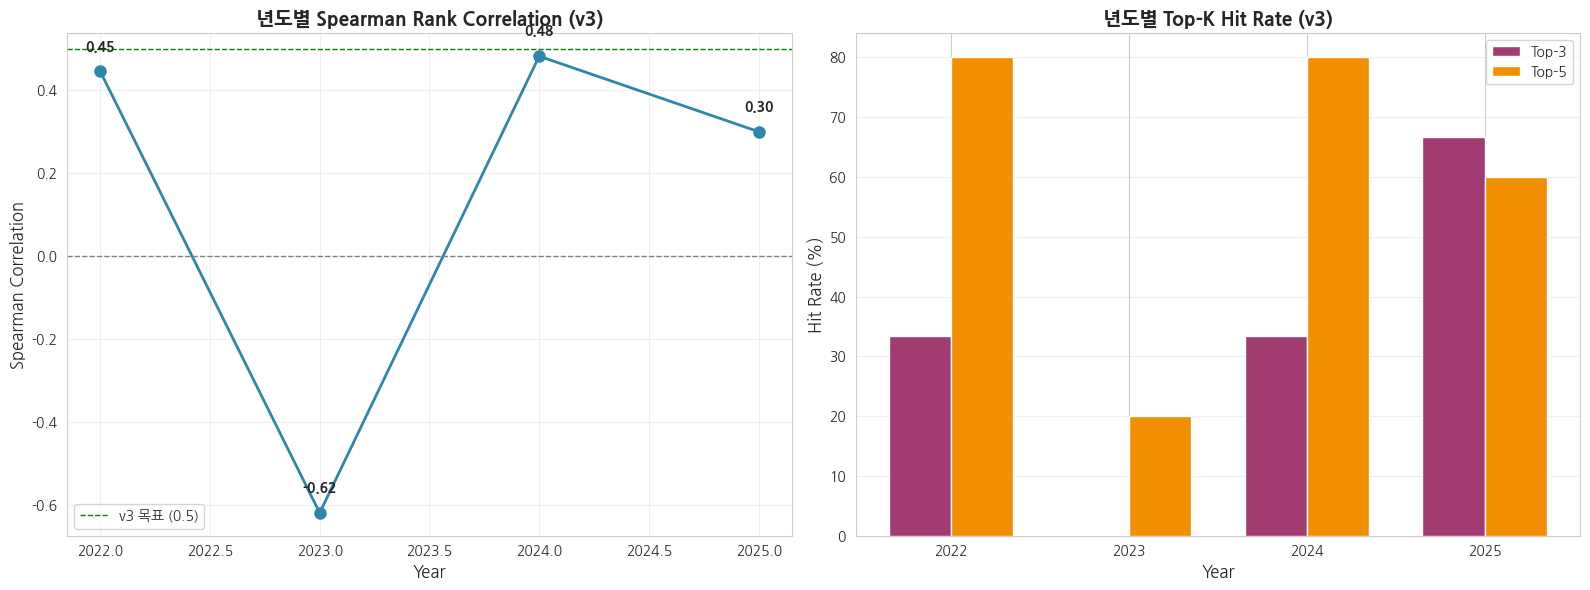


 시각화 완료: v3_evaluation_results.png 저장


In [31]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]
ax.plot(df_eval_summary['Year'], df_eval_summary['Spearman'], 
        marker='o', linewidth=2, markersize=8, color='#2E86AB')
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1)
ax.axhline(y=0.5, color='green', linestyle='--', linewidth=1, label='v3 목표 (0.5)')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Spearman Correlation', fontsize=12)
ax.set_title('년도별 Spearman Rank Correlation (v3)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

for i, row in df_eval_summary.iterrows():
    ax.text(row['Year'], row['Spearman'] + 0.05, f"{row['Spearman']:.2f}", 
            ha='center', fontsize=10, fontweight='bold')

ax = axes[1]
x = np.arange(len(df_eval_summary))
width = 0.35
ax.bar(x - width/2, df_eval_summary['Top3_Hit'], width, label='Top-3', color='#A23B72')
ax.bar(x + width/2, df_eval_summary['Top5_Hit'], width, label='Top-5', color='#F18F01')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Hit Rate (%)', fontsize=12)
ax.set_title('년도별 Top-K Hit Rate (v3)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_eval_summary['Year'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('v3_evaluation_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n 시각화 완료: v3_evaluation_results.png 저장")